In [1]:
import sys
sys.path.append('..')
import warnings
warnings.filterwarnings("ignore")


# standard
import json, pickle
from collections import defaultdict
import pandas as pd
import numpy as np
import seaborn as sns
from statistics import median
from matplotlib import pyplot as plt
from sklearn import metrics
import matplotlib.ticker as ticker
from itertools import combinations
from scipy import stats
import math
from matplotlib.ticker import FormatStrFormatter

# my lib
import PPILinkPred as pred
import genData_helper as helper
import traversalHelper as tr

In [2]:
def mean_confidence_interval(data, confidence=0.99):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    #return m, m-h, m+h
    return h

In [3]:
def standardize_plots(precsList, recsList, decimalPt):
    # note that the rec is trimmed in favor of the smallest rec (both min max)
    # corr recList to decimal pt -> create a rec list with minimum unit interval
    # -> map prec of each list to the rec list position, dont exists then np.nan -> use pandas interpolate
    corrStr = "{0:."+str(decimalPt)+"f}"
    tmp = []
    for recs in recsList: tmp.append(np.asarray([float(corrStr.format(rec)) for rec in recs]))
    recsList = tmp.copy()
    flattenRecs = np.asarray(recsList).flatten()
    minBoundRec, maxBoundRec = max([recs[0] for recs in recsList]), min([recs[-1] for recs in recsList])
    baseRecs = np.asarray([i for i in range(int(minBoundRec*(10**decimalPt)), int(maxBoundRec*(10**decimalPt)))])/10**decimalPt
    alignedPrecsList = []
    for i in range(len(precsList)):
        precsMap = {}
        for k in baseRecs: precsMap[k] = np.nan
        for j in range(len(precsList[i])):
            if recsList[i][j] in precsMap: precsMap[recsList[i][j]] = precsList[i][j]
        mappedPrecs = pd.Series(list(precsMap.values()))
        alignedPrecsList.append(list(np.asarray(mappedPrecs.interpolate())))
    return alignedPrecsList, baseRecs

def get_plots_outline(plots, boundFunc):
    # func can be: min, max, avg, median
    invertedArr = np.transpose(np.asarray(plots))
    boundPlot = [boundFunc(arr) for arr in invertedArr]
    return boundPlot

# init metadata

In [4]:
colors = {
    "L3E1_f1": "tab:blue",
    "L3E1_f2": "tab:olive",
    "L3E4_f1": "tab:cyan",
    "L3E4_f2": "tab:pink",
    "L3": "tab:orange",
    "CN": "tab:green",
    "CRA": "tab:red",
    "CH2": "tab:brown",
    "Sim": "tab:purple",
    "rand": "tab:grey"
}

methods = ["commonNeighbor", "L3Normalizing", "CRA", "Sim", "CH2_L3", "random"]+["L3E1_{}".format(i) for i in ['f1', 'f2']]
methods_map = ["CN", "L3", "CRA", "Sim", "CH2", "rand"]+["L3E1_{}".format(i) for i in ['f1', 'f2']]
abbrev_map = ["CN", "L3", "CRA", "Sim", "CH2", "rand"]+["L3E\n($f_{"+str(i)+"}$)" for i in range(1,3)]
label_map = ["CN", "L3", "CRA", "Sim", "CH2", "rand"]+["L3E($f_{"+str(i)+"}$)" for i in range(1,3)]

methods_names = dict(zip(methods, methods_map))
abbrevs = dict(zip(methods_map, abbrev_map))
labels = dict(zip(methods_map, label_map))

# read data into df

In [5]:
# import all prec rec into data structure:
# col: rank, method, ds, trial, prec, rec

methods = ["commonNeighbor", "L3Normalizing", "CRA", "Sim", "CH2_L3", "L3E1_f1", "L3E1_f2", "random"]
ds_names = ['bioGRID', 'STRING', 'MINT']

df = defaultdict(list)

for ds in ds_names:
    for method in methods:
        for i in range(0,10):
            precRec = {}
            with open("./precision_recall_out/{}_{}_topPPI_{}.json".format(method, ds, i), "r") as f:
                precRec = json.loads(f.read())

                df["randSz"] += [50 for j in range(len(precRec['prec']))]
                df["rank"] += [j for j in range(len(precRec['prec']))]
                df['method'] += [methods_names[method] for j in range(len(precRec['prec']))]
                df['ds'] += [ds for j in range(len(precRec['prec']))]
                df['trial'] += [int(i) for j in range(len(precRec['prec']))]
                df['prec'] += precRec['prec']
                df['rec'] += precRec['rec']

for randSz in range(60, 100, 10):
    for ds in ds_names:
        for method in methods:
            for i in range(0,10):
                precRec = {}
                with open("./precision_recall_out/{}_{}_randSz{}_topPPI_{}.json".format(method, ds, randSz, i), "r") as f:
                    precRec = json.loads(f.read())

                    df["randSz"] += [randSz for j in range(len(precRec['prec']))]
                    df["rank"] += [j for j in range(len(precRec['prec']))]
                    df['method'] += [methods_names[method] for j in range(len(precRec['prec']))]
                    df['ds'] += [ds for j in range(len(precRec['prec']))]
                    df['trial'] += [int(i) for j in range(len(precRec['prec']))]
                    df['prec'] += precRec['prec']
                    df['rec'] += precRec['rec']
                
df = pd.DataFrame(df)
df

,randSz,rank,method,ds,trial,prec,rec
0,50,0,CN,bioGRID,0,1.0,0.000018
1,50,1,CN,bioGRID,0,1.0,0.000035
2,50,2,CN,bioGRID,0,1.0,0.000053
3,50,3,CN,bioGRID,0,1.0,0.000071
4,50,4,CN,bioGRID,0,1.0,0.000088
...,...,...,...,...,...,...,...
26946715,90,1686,rand,MINT,9,0.0,0.000000
26946716,90,1687,rand,MINT,9,0.0,0.000000
26946717,90,1688,rand,MINT,9,0.0,0.000000
26946718,90,1689,rand,MINT,9,0.0,0.000000


In [124]:
df.to_pickle("./precision_recall_out/full_df.pkl")

In [5]:
df = pd.read_pickle("./precision_recall_out/full_df.pkl")

# AUC of precision-recall, ranked from low to high

In [8]:
auc_map = {}
methods = ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2", "rand"]

for randSz in range(50, 91, 10):
    auc_map[randSz] = {}
    for ds in set(df['ds']):
        auc_map[randSz][ds] = defaultdict(list)
        for method in methods:
            tmp_df = df[(df['ds'] == ds) & (df['method'] == method) & (df['randSz'] == randSz)]
            prec = [list(tmp_df[tmp_df['trial'] == trial]['prec'])[100:] for trial in set(tmp_df['trial'])]
            rec = [list(tmp_df[tmp_df['trial'] == trial]['rec'])[100:] for trial in set(tmp_df['trial'])]
            for i in range(len(prec)):
                auc_map[randSz][ds][method].append(metrics.auc(rec[i], prec[i]))
            

sorted_mean_auc, err_auc = {}, {}
for randSz in range(50, 91, 10):
    sorted_mean_auc[randSz], err_auc[randSz] = {}, {}
    for ds in auc_map[randSz]:
        sorted_mean_auc[randSz][ds], err_auc[randSz][ds] = {}, {}
        for method in auc_map[randSz][ds]:
            sorted_mean_auc[randSz][ds][method] = np.mean(auc_map[randSz][ds][method])
            err_auc[randSz][ds][method] = np.std(auc_map[randSz][ds][method])
        sorted_mean_auc[randSz][ds] = dict(sorted(sorted_mean_auc[randSz][ds].items(), key=lambda item: item[1]))

print(sorted_mean_auc)

{50: {'bioGRID': {'rand': 7.582320640920637e-06, 'CN': 0.059105628753706105, 'Sim': 0.06698495593962117, 'CRA': 0.0935578609311186, 'L3': 0.10286552643626798, 'L3E1_f2': 0.10837767858420036, 'CH2': 0.11118983825094655, 'L3E1_f1': 0.14104255973992252}, 'STRING': {'rand': 2.4938190694241533e-05, 'CH2': 0.2841731521655968, 'Sim': 0.3129469819403806, 'L3': 0.3274289671072244, 'L3E1_f2': 0.3517995098143162, 'CN': 0.361281961850816, 'L3E1_f1': 0.39032348955829466, 'CRA': 0.43662115292900044}, 'MINT': {'rand': 2.247122680139217e-06, 'CRA': 0.06300664211614702, 'CN': 0.06752841563913219, 'Sim': 0.10199408449364074, 'L3E1_f2': 0.11202714492530083, 'CH2': 0.12321230294881391, 'L3': 0.13076471346062984, 'L3E1_f1': 0.1391037737179351}}, 60: {'bioGRID': {'rand': 4.725798928092831e-06, 'CN': 0.051415911170567964, 'Sim': 0.05567883030861209, 'CH2': 0.08379729231539289, 'L3': 0.08475968280062639, 'CRA': 0.09167664306618868, 'L3E1_f2': 0.0934081462201845, 'L3E1_f1': 0.1224382318888911}, 'STRING': {'ran

In [10]:
# the decreasing AUC of rand
dss = ['bioGRID', 'STRING', 'MINT']
dsNames = ['BioGRID Yeast', 'STRING Yeast', 'MINT Yeast']

for i in range(len(dss)):
    ds = dss[i]
    buildStr = ""
    for randSz in range(50, 100, 10):
        aucVal = np.format_float_scientific(np.float32(sorted_mean_auc[randSz][ds]['rand']), precision=3)
        buildStr += " & "+str(aucVal)
    print("\\cellcolor{gray!15} "+dsNames[i]+" "+buildStr+" \\\\ \\hline")

\cellcolor{gray!15} BioGRID Yeast  & 7.582e-06 & 4.726e-06 & 2.267e-06 & 1.262e-06 & 3.027e-07 \\ \hline
\cellcolor{gray!15} STRING Yeast  & 2.494e-05 & 1.529e-05 & 8.408e-06 & 3.908e-06 & 9.452e-07 \\ \hline
\cellcolor{gray!15} MINT Yeast  & 2.247e-06 & 1.009e-06 & 5.536e-07 & 4.933e-07 & 0.e+00 \\ \hline


50


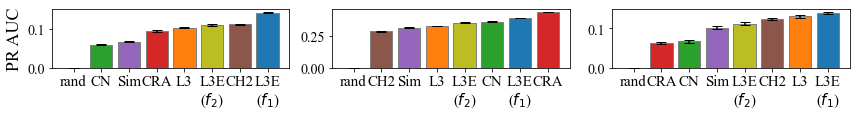

60


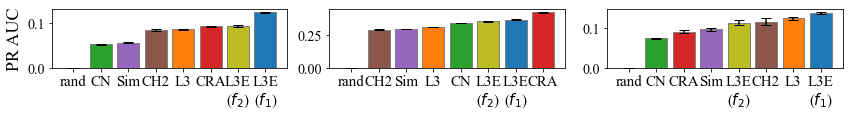

70


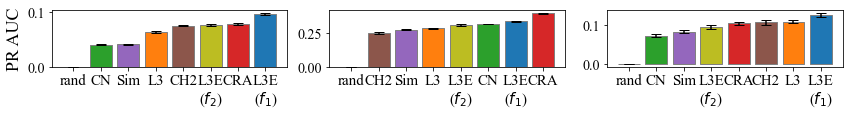

80


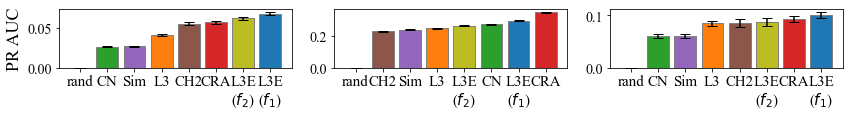

90


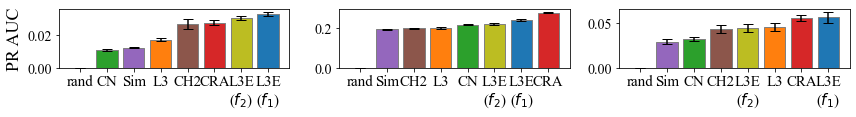

In [12]:
# auc bar plot, with rand
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=13)
plt.rcParams["font.family"] = "Times New Roman"

dss = ['bioGRID', 'STRING', 'MINT']
for randSz in range(50, 91, 10):
    print(randSz)
    fig, axes = plt.subplots(1, 3, figsize=(12, 1.7))
    for i in range(len(dss)):
        ds = dss[i]
        ax = axes[i]

        xtick = [k for k in list(sorted_mean_auc[randSz][ds])]
        xtick = [k for k in list(sorted_mean_auc[randSz][ds])]
        ax.bar([abbrevs[x] for x in xtick], [sorted_mean_auc[randSz][ds][x] for x in xtick]
                          , yerr=[err_auc[randSz][ds][x] for x in xtick]
                          , color=[colors[x] for x in xtick]
                          , edgecolor='grey', capsize=5)

        #hatches = ['/' if ('L3E' in x) else '' for x in xtick]
        #ax = plt.gca()    
        #for i, patch in enumerate(ax.patches): patch.set_hatch(hatches[i])

    axes[0].set_ylabel("PR AUC")
    plt.tight_layout()
    plt.savefig("./img_experiments/full_prAUC_randSz{}_wRand.png".format(randSz), dpi=300)
    plt.show()

50


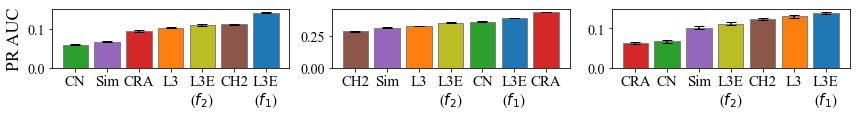

60


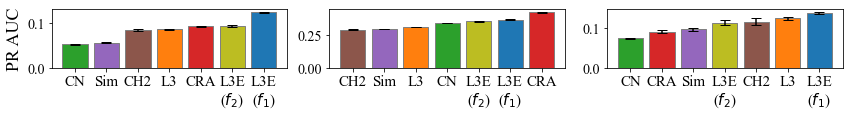

70


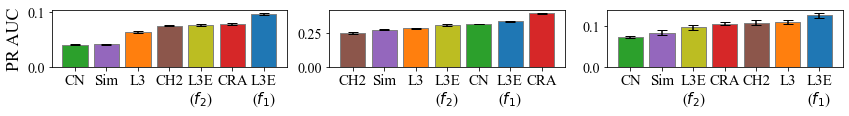

80


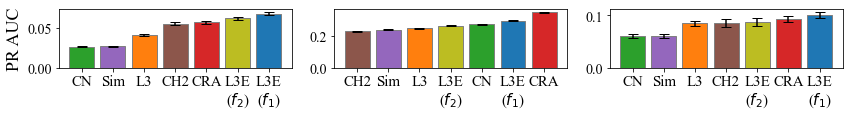

90


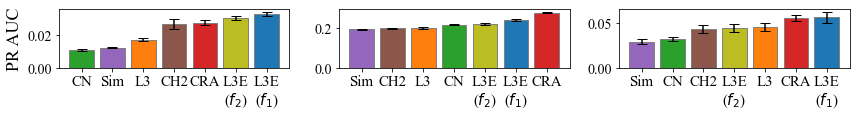

In [14]:
# auc bar plot
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=13)
plt.rcParams["font.family"] = "Times New Roman"

dss = ['bioGRID', 'STRING', 'MINT']
for randSz in range(50, 91, 10):
    print(randSz)
    fig, axes = plt.subplots(1, 3, figsize=(12, 1.7))
    for i in range(len(dss)):
        ds = dss[i]
        ax = axes[i]

        xtick = [k for k in list(sorted_mean_auc[randSz][ds])]
        xtick = [k for k in list(sorted_mean_auc[randSz][ds])]
        ax.bar([abbrevs[x] for x in xtick], [sorted_mean_auc[randSz][ds][x] for x in xtick]
                          , yerr=[err_auc[randSz][ds][x] for x in xtick]
                          , color=[colors[x] for x in xtick]
                          , edgecolor='grey', capsize=5)

        #hatches = ['/' if ('L3E' in x) else '' for x in xtick]
        #ax = plt.gca()    
        #for i, patch in enumerate(ax.patches): patch.set_hatch(hatches[i])

    axes[0].set_ylabel("PR AUC")
    plt.tight_layout()
    plt.savefig("./img_experiments/full_prAUC_randSz{}.png".format(randSz), dpi=300)
    plt.show()

# p-value of PR AUC

In [15]:
# p val
# sample to do: top 2 both to third, between top 2
pairs = [['L3E1_f1', 'CH2'], ['L3E1_f1', 'CRA'], ['L3E1_f1', 'L3']]
randSz = 50
for i in range(len(dss)):
    ds = dss[i]
    pop1 = auc_map[randSz][ds][pairs[i][0]]
    pop2 = auc_map[randSz][ds][pairs[i][1]]
    pVal = stats.ttest_ind(pop1, pop2)[1]
    print("{} {}: {}".format(pairs[i][0], pairs[i][1], pVal))

L3E1_f1 CH2: 2.0662224875518246e-18
L3E1_f1 CRA: 1.0692542059555007e-20
L3E1_f1 L3: 2.263749131674782e-05


In [11]:
pairs = {
    60: [['L3E1_f2', 'L3E1_f1'], ['CRA', 'L3E1_f1'], ['L3E1_f1', 'L3']],
    70: [['L3E1_f1', 'CRA'], ['CRA', 'L3E1_f1'], ['L3E1_f1', 'L3']],
    80: [['L3E1_f2', 'L3E1_f1'], ['CRA', 'L3E1_f1'], ['CRA', 'L3E1_f1']],
    90: [['L3E1_f1', 'L3E1_f2'], ['CRA', 'L3E1_f1'], ['CRA', 'L3E1_f1']]
}
dss = ['bioGRID', 'STRING', 'MINT']
for randSz in range(60, 100, 10):
    print(randSz)
    for i in range(len(dss)):
        ds = dss[i]
        pair = pairs[randSz][i]
        pop1 = auc_map[randSz][ds][pair[0]]
        pop2 = auc_map[randSz][ds][pair[1]]
        pVal = stats.ttest_ind(pop1, pop2)[1]
        print("{} {} {}: {}".format(ds, pair[0], pair[1], pVal))

60
bioGRID L3E1_f2 L3E1_f1: 4.6536085005152854e-17
STRING CRA L3E1_f1: 3.939934347738852e-19
MINT L3E1_f1 L3: 2.4786423889691935e-08
70
bioGRID L3E1_f1 CRA: 9.718391246120536e-15
STRING CRA L3E1_f1: 1.3504634874519485e-18
MINT L3E1_f1 L3: 1.246711376530459e-06
80
bioGRID L3E1_f2 L3E1_f1: 1.83324813986452e-05
STRING CRA L3E1_f1: 1.3110721875796383e-15
MINT CRA L3E1_f1: 0.013131585256036093
90
bioGRID L3E1_f1 L3E1_f2: 0.0019572289134463274
STRING CRA L3E1_f1: 1.3178335086740008e-13
MINT CRA L3E1_f1: 0.7873819683160069


In [12]:
# every p val to rand
# sample to do: top 2 both to third, between top 2
for randSz in range(50, 100, 10):
    print(randSz)
    for i in range(len(dss)):
        ds = dss[i]
        for pair in [['rand', x] for x in ["CN", "CRA", "L3", "CH2", "Sim", "L3E1_f1", "L3E1_f2"]]:
            pop1 = auc_map[randSz][ds][pair[0]]
            pop2 = auc_map[randSz][ds][pair[1]]
            pVal = stats.ttest_ind(pop1, pop2)[1]
            print("{} {} {}: {}".format(ds, pair[0], pair[1], pVal))

50
bioGRID rand CN: 4.093831730637693e-27
bioGRID rand CRA: 1.2322965679347075e-29
bioGRID rand L3: 1.431567295070378e-34
bioGRID rand CH2: 2.986364831511628e-34
bioGRID rand Sim: 3.5579908855942085e-26
bioGRID rand L3E1_f1: 1.4494862637043889e-31
bioGRID rand L3E1_f2: 5.066611799175532e-29
STRING rand CN: 8.841272451692345e-38
STRING rand CRA: 5.466158182515257e-42
STRING rand L3: 5.222799069825857e-37
STRING rand CH2: 1.000925688515644e-33
STRING rand Sim: 2.7373300921008285e-36
STRING rand L3E1_f1: 3.306918052289817e-39
STRING rand L3E1_f2: 2.106167399228267e-36
MINT rand CN: 6.020083636453574e-21
MINT rand CRA: 3.7700714839505714e-25
MINT rand L3: 1.2326465157354476e-28
MINT rand CH2: 1.5069375920536184e-28
MINT rand Sim: 1.530007240604279e-24
MINT rand L3E1_f1: 7.659748528794864e-28
MINT rand L3E1_f2: 2.552396326157304e-26
60
bioGRID rand CN: 1.0751146956559287e-28
bioGRID rand CRA: 2.4265064394100775e-29
bioGRID rand L3: 1.2438190576167137e-34
bioGRID rand CH2: 4.484572006443905e

# precision-recall figure

In [10]:
precRec = {}
methods = ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2", "rand"]

for randSz in range(50, 100, 10):
    precRec[randSz] = {}
    for ds in ds_names:
        precRec[randSz][ds] = defaultdict(dict)
        for method in methods:
            tmp_df = df[(df['ds'] == ds) & (df['method'] == method) & (df['randSz'] == randSz)]
            prec = [list(tmp_df[tmp_df['trial'] == trial]['prec'])[100:] for trial in set(tmp_df['trial'])]
            rec = [list(tmp_df[tmp_df['trial'] == trial]['rec'])[100:] for trial in set(tmp_df['trial'])]
            alignedPrecs, baseRec = standardize_plots(prec, rec, 5)
            upperPrec, lowerPrec, medianPrec = get_plots_outline(alignedPrecs, max), get_plots_outline(alignedPrecs, min), get_plots_outline(alignedPrecs, median)
            precRec[randSz][ds][method]['upperPrec'] = upperPrec
            precRec[randSz][ds][method]['lowerPrec'] = lowerPrec
            precRec[randSz][ds][method]['medianPrec'] = medianPrec
            precRec[randSz][ds][method]['baseRec'] = baseRec
with open("./precision_recall_out/precRecCurves.pkl", "wb") as f:
    pickle.dump(precRec, f, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
precRec = {}
with open("./precision_recall_out/precRecCurves.pkl", "rb") as f:
    precRec = pickle.load(f)

50
bioGRID
STRING
MINT


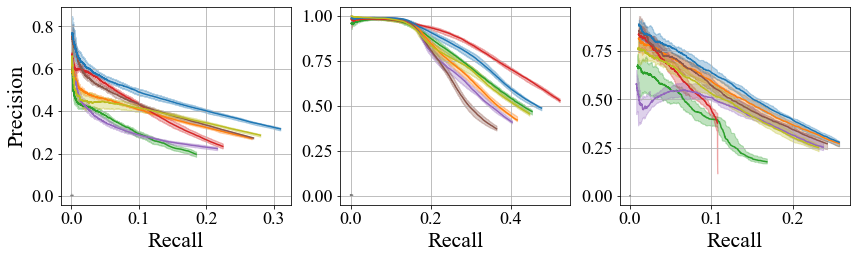

60
bioGRID
STRING
MINT


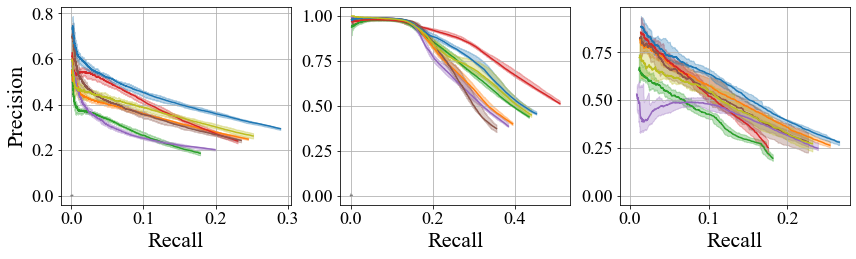

70
bioGRID
STRING
MINT


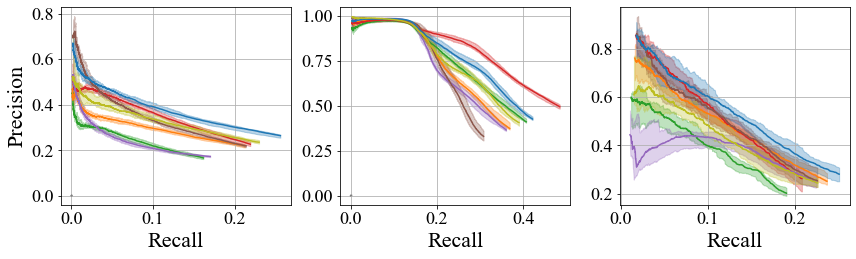

80
bioGRID
STRING
MINT


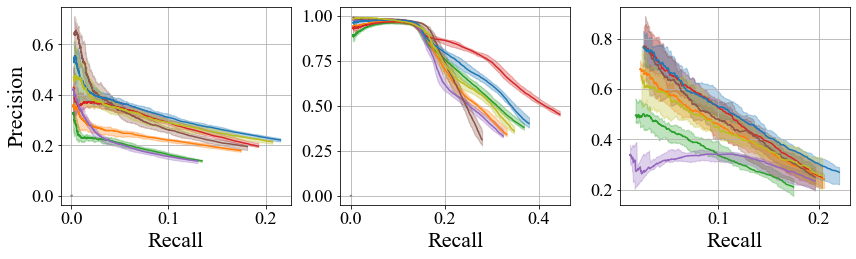

90
bioGRID
STRING
MINT


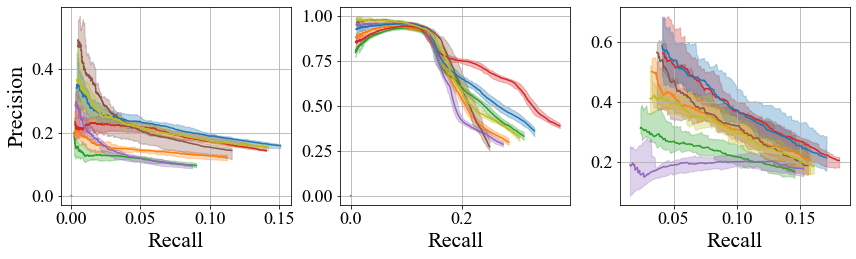

In [12]:
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=22)
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rcParams["font.family"] = "Times New Roman"


for randSz in range(50, 100, 10):
    print(randSz)
    fig, axes = plt.subplots(1, 3, figsize=(12, 3.7))
    dss = ['bioGRID', 'STRING', 'MINT']
    for i in range(len(dss)):
        ds = dss[i]
        print(ds)
        ax = axes[i]
        for method in ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2", "rand"]:
            ax.fill_between(precRec[randSz][ds][method]['baseRec']
                            , precRec[randSz][ds][method]['lowerPrec']
                            , precRec[randSz][ds][method]['upperPrec']
                            , facecolor=colors[method], color=colors[method]
                            , alpha=0.3)
            ax.plot(precRec[randSz][ds][method]['baseRec']
                    , precRec[randSz][ds][method]['medianPrec']
                    , color=colors[method], label=method)

            ax.set_xlabel("Recall")
            #ax.spines['right'].set_visible(False)
            #ax.spines['top'].set_visible(False)

    axes[0].set_ylabel("Precision")
    for i in range(len(dss)): axes[i].grid()
    #ttl = ax.title
    #ttl.set_position([.5, 1.02])

    plt.tight_layout()
    plt.savefig('./img_experiments/randSz{}_PR_wRand.png'.format(randSz), dpi=300)
    plt.show()

# F1 score scatter

In [9]:
# F1 score 50% into the curve
f1Func = lambda prec, rec: 2*(prec*rec)/(prec+rec)
f1Scores, f1Scores_err = defaultdict(dict), defaultdict(dict)
for ds in ['bioGRID', 'STRING', 'MINT']:
    for method in ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2"]:
        f1Scores[ds][method], f1Scores_err[ds][method] = [], []
        for randSz in precRec:
            fullLen = len(precRec[randSz][ds][method]['medianPrec'])
            f1Score = f1Func(precRec[randSz][ds][method]['medianPrec'][int(fullLen*0.5)]
                , precRec[randSz][ds][method]['baseRec'][int(fullLen*0.5)])
            
            f1Scores[ds][method].append(f1Score)
            f1Scores_err[ds][method].append([
                
                f1Score-f1Func(precRec[randSz][ds][method]['lowerPrec'][int(fullLen*0.5)]
                    , precRec[randSz][ds][method]['baseRec'][int(fullLen*0.5)])
                
                , f1Func(precRec[randSz][ds][method]['upperPrec'][int(fullLen*0.5)]
                , precRec[randSz][ds][method]['baseRec'][int(fullLen*0.5)])-f1Score
                
            ])

bioGRID
STRING
MINT


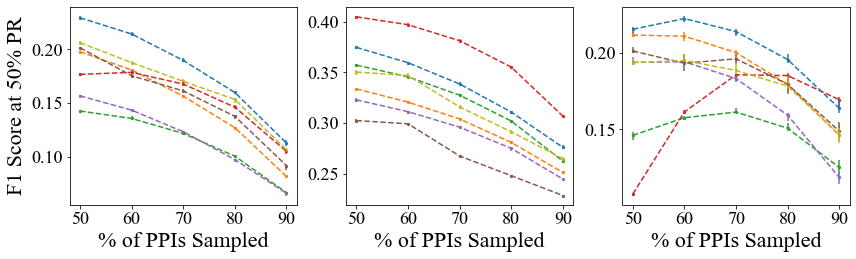

In [10]:
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=22)
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rcParams["font.family"] = "Times New Roman"

fig, axes = plt.subplots(1, 3, figsize=(12, 3.7))
dss = ['bioGRID', 'STRING', 'MINT']
for i in range(len(dss)):
    ds = dss[i]
    print(ds)
    ax = axes[i]
    for method in ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2"]:
        ax.errorbar([randSz for randSz in range(50, 100, 10)]
                    , f1Scores[ds][method], fmt='--', color=colors[method]
                    , yerr=np.transpose(np.asarray(f1Scores_err[ds][method])))
        ax.scatter([randSz for randSz in range(50, 100, 10)]
                    , f1Scores[ds][method], s=5, color=colors[method])
        ax.set_xlabel("% of PPIs Sampled")
    #ax.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
    ax.set_xticks([randSz for randSz in range(50, 100, 10)])
axes[0].set_ylabel("F1 Score at 50% PR")
plt.tight_layout()
plt.savefig('./img_experiments/full_F1_50%.png'.format(randSz), dpi=300)
plt.show()

# F1 score AUC

In [8]:
auc_map = {}
methods = ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2"]
f1Func = lambda prec, rec: 2*(prec*rec)/(prec+rec)

for ds in set(df['ds']):
    auc_map[ds] = defaultdict(list)
    for method in methods:
        tmp_df = df[(df['ds'] == ds) & (df['method'] == method)]
        for  trial in range(10):
            f1Scores = []
            for randSz in range(50, 100, 10):
                prec = list(tmp_df[(tmp_df['trial'] == trial) & (tmp_df['randSz'] == randSz)]['prec'])
                rec = list(tmp_df[(tmp_df['trial'] == trial) & (tmp_df['randSz'] == randSz)]['rec'])
                f1Scores.append(f1Func(prec[int(len(prec)*0.5)], rec[int(len(rec)*0.5)]))
            auc_map[ds][method].append(metrics.auc([j/100 for j in range(50, 100, 10)], f1Scores))
            

sorted_mean_auc, err_auc = {}, {}
for ds in auc_map:
    sorted_mean_auc[ds], err_auc[ds] = {}, {}
    for method in auc_map[ds]:
        sorted_mean_auc[ds][method] = np.mean(auc_map[ds][method])
        err_auc[ds][method] = np.std(auc_map[ds][method])
    sorted_mean_auc[ds] = dict(sorted(sorted_mean_auc[ds].items(), key=lambda item: item[1]))

print(sorted_mean_auc)

{'STRING': {'CH2': 0.13858241534815413, 'Sim': 0.14208810193214366, 'L3': 0.14760428874364898, 'L3E1_f2': 0.159031890937159, 'CN': 0.15950184821109395, 'L3E1_f1': 0.16932290801815597, 'CRA': 0.1846281861257149}, 'MINT': {'CN': 0.0739628429404606, 'CRA': 0.08405823428124073, 'Sim': 0.08511726964526493, 'L3E1_f2': 0.08863826395669427, 'CH2': 0.08983284569510588, 'L3': 0.09209258180624615, 'L3E1_f1': 0.09795700820889293}, 'bioGRID': {'Sim': 0.05335030985928354, 'CN': 0.05441213020255792, 'L3': 0.06944723441335401, 'CH2': 0.07269569609770211, 'CRA': 0.07566349769468773, 'L3E1_f2': 0.07754452038738788, 'L3E1_f1': 0.08482484740613173}}


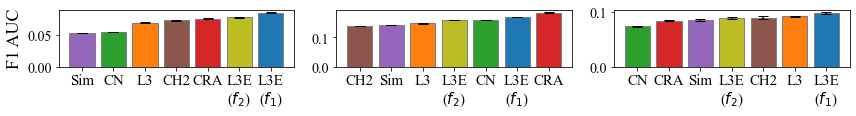

In [9]:
# auc bar plot
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=13)
plt.rcParams["font.family"] = "Times New Roman"

fig, axes = plt.subplots(1, 3, figsize=(12, 1.7))

dss = ['bioGRID', 'STRING', 'MINT']
for i in range(len(dss)):
    ds = dss[i]
    ax = axes[i]
    
    xtick = [k for k in list(sorted_mean_auc[ds])]
    xtick = [k for k in list(sorted_mean_auc[ds])]
    ax.bar([abbrevs[x] for x in xtick], [sorted_mean_auc[ds][x] for x in xtick]
                      , yerr=[err_auc[ds][x] for x in xtick]
                      , color=[colors[x] for x in xtick]
                      , edgecolor='grey', capsize=5)

axes[0].set_ylabel("F1 AUC")
plt.tight_layout()
plt.savefig("./img_experiments/full_F1AUC_50%.png", dpi=300)
plt.show()

In [10]:
# p val
# sample to do: top 2 both to third, between top 2
pairs = [['L3E1_f1', 'L3E1_f2'], ['L3E1_f1', 'CRA'], ['L3E1_f1', 'L3']]
for i in range(len(dss)):
    ds = dss[i]
    pop1 = auc_map[ds][pairs[i][0]]
    pop2 = auc_map[ds][pairs[i][1]]
    pVal = stats.ttest_ind(pop1, pop2)[1]
    print("{} {}: {}".format(pairs[i][0], pairs[i][1], pVal))

L3E1_f1 L3E1_f2: 2.7569618197160904e-14
L3E1_f1 CRA: 4.136451892012699e-19
L3E1_f1 L3: 2.3135846501634397e-09
